# 零基础实战机器学习 源代码

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438

## 导入数据

In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


## 数据可视化

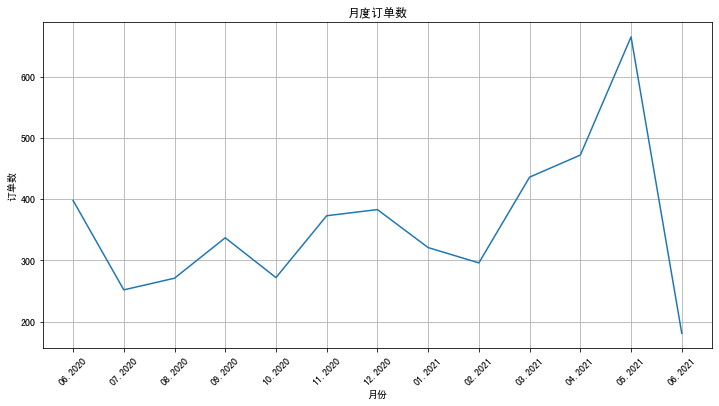

In [2]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
#构建月度的订单数的DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

## 数据清洗

In [3]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

In [4]:
df_sales.isna().sum() # NaN出现的次数

订单号     0
产品码     0
消费日期    0
产品说明    0
数量      0
单价      0
用户码     0
城市      0
dtype: int64

In [5]:
df_sales.describe() #df_sales的统计信息

,数量,单价,用户码
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


In [6]:
df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据

In [7]:
df_sales.describe() #df_sales的统计信息

,数量,单价,用户码
count,84112.000000,84112.000000,84112.000000
mean,10.760236,3.005032,15337.732963
std,34.018906,15.365085,392.074855
min,1.000000,0.000000,14681.000000
25%,2.000000,1.250000,15021.000000
50%,5.000000,1.950000,15333.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,3155.950000,16019.000000


## 特征工程

In [8]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


## 构建User用户表

In [9]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


## 求R值

In [10]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


## 求F值

In [11]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


## 求M值

In [12]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10
